In [38]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import words
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
from time import time
from sklearn.preprocessing import label_binarize
# from nltk.metrics.distance  import edit_distance

In [2]:
PATH = './data/'
NLTK_PATH = './nltk_data/'
pd.set_option("max_colwidth", 400)

# Replace unencodable character by questionmark

In [3]:
def sanitize_characters(input_file, output_file):    
    with open(file=PATH+input_file, mode="r", encoding='utf-8', errors='replace') as f_in:
        data = f_in.read()
        with open(file=PATH+output_file, mode="w", encoding='utf-8') as f_out:
            f_out.write(data)

sanitize_characters("processedNegative.csv", "negative_clean")
sanitize_characters("processedNeutral.csv", "neutral_clean")
sanitize_characters("processedPositive.csv", "positive_clean")

# Read a file

In [4]:
def get_data(input_file, sep, class_label):
    with open(PATH+input_file, 'r') as f_in:
        text = f_in.read()
    df = pd.DataFrame(text.split(sep), columns=['Text'])
    df['Class'] = class_label
    return df

negative = get_data("processedNegative.csv", ' ,', -1)
neutral = get_data("processedNeutral.csv", ' ,', 0)

In [5]:
negative.head()

,Text,Class
0,"How unhappy some dogs like it though,talking to my over driver about where I'm goinghe said he'd love to go to New York too but since Trump it's probably not,Does anybody know if the Rand's likely to fall against the dollar? I got some money I need to change into R but it keeps getting stronger unhappy",-1
1,I miss going to gigs in Liverpool unhappy,-1
2,There isnt a new Riverdale tonight ? unhappy,-1
3,it's that A*dy guy from pop Asia and then the translator so they'll probs go with them around Aus unhappy,-1
4,"Who's that chair you're sitting in? Is this how I find out. Everyone knows now. You've shamed me in pu,don't like how jittery caffeine makes me sad",-1


In [6]:
neutral.head()

,Text,Class
0,"Pak PM survives removal scare, but court orders further probe into corruption charge.",0
1,"Supreme Court quashes criminal complaint against cricketer for allegedly depicting himself as on magazine cover.,Art of Living's fights back over Yamuna floodplain damage, livid.",0
2,FCRA slap on NGO for lobbying...But was it doing so as part of govt campaign?,0
3,"Why doctors, pharma companies are opposing names on",0
4,Why a bicycle and not a CM asked. His officer learnt ground reality -- and a dip in a river.,0


## Save positive

In [7]:
def join_beginspace(lst):
    new_lst = []
    i = 0
    change = 0
    while i < len(lst):
        if lst[i] == '':
            i += 1
            continue
        if i < len(lst)-1:
            if lst[i+1] == '':
                i += 1
                continue
            if lst[i+1][0] == ' ':
                new_lst.append(lst[i]+lst[i+1])
                i += 2
                change = 1
                continue
        new_lst.append(lst[i])
        i += 1
    return(new_lst, change)


def join_endspace(lst):
    new_lst = []
    i = 0
    change = 0
    while i < len(lst):
        if lst[i] == '':
            i += 1
            continue
        if i+1 < len(lst):
            if lst[i+1] == '':
                i += 1
                continue
            if (lst[i][-1] == ' '):
                new_lst.append(lst[i]+lst[i+1])
                i += 2
                change = 1
                continue;
        new_lst.append(lst[i])
        i += 1
    return(new_lst, change)

In [8]:
def get_list(input_file, sep):
    with open(PATH+input_file, 'r') as f_in:
        text = f_in.read()
    return text.split(sep)

lst = get_list("processedPositive.csv", ',')
change = 1
while(change == 1):
    lst, change = join_beginspace(lst)
change = 1
while(change == 1):
    lst, change = join_endspace(lst)
positive = pd.DataFrame(lst, columns=['Text'])
positive['Class'] = 1

In [9]:
positive.head()

,Text,Class
0,An inspiration in all aspects: Fashion fitness beauty and personality. :)KISSES TheFashionIcon,1
1,Apka Apna Awam Ka Channel Frankline Tv Aam Admi Production Please Visit Or Likes Share :)Fb Page :...,1
2,Beautiful album from the greatest unsung guitar genius of our time - and I've met the great backstage,1
3,Good luck to Rich riding for great project in this Sunday. Can you donate?,1
4,Omg he... kissed... him crying with joy,1


In [10]:
df = pd.concat([negative, neutral, positive], ignore_index=True)
df.head()

,Text,Class
0,"How unhappy some dogs like it though,talking to my over driver about where I'm goinghe said he'd love to go to New York too but since Trump it's probably not,Does anybody know if the Rand's likely to fall against the dollar? I got some money I need to change into R but it keeps getting stronger unhappy",-1
1,I miss going to gigs in Liverpool unhappy,-1
2,There isnt a new Riverdale tonight ? unhappy,-1
3,it's that A*dy guy from pop Asia and then the translator so they'll probs go with them around Aus unhappy,-1
4,"Who's that chair you're sitting in? Is this how I find out. Everyone knows now. You've shamed me in pu,don't like how jittery caffeine makes me sad",-1


In [11]:
df.tail()

,Text,Class
2703,Thanks for the recent follow Happy to connect happy have a great Thursday. Get this,1
2704,- top engaged members this week happy,1
2705,ngam to weeks left for cadet pilot exam crying with joy,1
2706,Great! You're welcome Josh happy ^Adam,1
2707,Sixth spot not applicable Team! Higher pa! :)KISSES TheFashionIcon,1


In [12]:
df.describe()

,Class
count,2708.000000
mean,0.057976
std,0.819033
min,-1.000000
25%,-1.000000
50%,0.000000
75%,1.000000
max,1.000000


# cleaning text

In [13]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df[text_field] = df[text_field].str.replace(r",,", ",", regex=True)
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'Text')
df.head()

,Text,Class
0,"how unhappy some dogs like it though,talking to my over driver about where i'm goinghe said he'd love to go to new york too but since trump it's probably not,does anybody know if the rand's likely to fall against the dollar? i got some money i need to change into r but it keeps getting stronger unhappy",-1
1,i miss going to gigs in liverpool unhappy,-1
2,there isnt a new riverdale tonight ? unhappy,-1
3,it's that a dy guy from pop asia and then the translator so they'll probs go with them around aus unhappy,-1
4,"who's that chair you're sitting in? is this how i find out everyone knows now you've shamed me in pu,don't like how jittery caffeine makes me sad",-1


### Data Overview

In [14]:
my_classes = df.Class.unique()
df.groupby('Class').count()

,Text
Class,
-1,834
0,883
1,991


# Functions

In [15]:
def tokenize_text(text, approach):
    if approach=='stemming':
        ps =PorterStemmer()
    elif approach=='lemmatization':
        lemmatizer = WordNetLemmatizer()
    elif approach=='stemming+misspelling':
        ps = PorterStemmer()
        correct_spellings = words.words()
    elif approach=='lemmatization+misspelling':
        lemmatizer = WordNetLemmatizer()
        correct_spellings = words.words()
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            if word in stopwords.words('english'):
                continue
            if word[0] == "'" or word[0] in ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'):
                continue
            
            if approach=='stemming':
                tokens.append(ps.stem(word))
            elif approach=='lemmatization':
                tokens.append(lemmatizer.lemmatize(word))
            elif approach=='stemming+misspelling':
                after_stem = ps.stem(word)
                if after_stem in correct_spellings:
                    tokens.append(after_stem)
                else:
                    after_correct = [
                        (jaccard_distance(set(ngrams(after_stem, 2)), 
                                          set(ngrams(w, 2))),w) for w in correct_spellings if w[0]==after_stem[0]
                        ]
                    if after_correct:
                        tokens.append(sorted(after_correct, key = lambda val:val[0])[0][1])
                    else:
                        print(word, after_stem)
                        tokens.append(after_stem)
            elif approach=='lemmatization+misspelling':
                after_lemm = lemmatizer.lemmatize(word)
                if after_lemm in correct_spellings:
                    tokens.append(after_lemm)
                else:
                    after_correct = [
                        (jaccard_distance(set(ngrams(after_lemm, 2)), 
                                          set(ngrams(w, 2))),w) for w in correct_spellings if w[0]==after_lemm[0]
                        ]
                    if after_correct:
                        tokens.append(sorted(after_correct, key = lambda val:val[0])[0][1])
                    else:
                        print(word, after_lemm)
                        tokens.append(after_lemm)

            else:
                tokens.append(word)
                
    return tokens

In [16]:
def get_matrix(sentence, mode):
    t = Tokenizer()
    t.fit_on_texts(sentence)
    return t.texts_to_matrix(sentence, mode=mode)#'binary')

In [17]:
APPROACHES = ['just tokenization', 'stemming', 'lemmatization', 
            'stemming+misspelling', 'lemmatization+misspelling']
encoded_docs = pd.DataFrame(data = None, 
                            index=APPROACHES, 
                            columns=['0 or 1, if the word exists', 'word counts', 'TFIDF'])
accuracy_matrix = encoded_docs.copy()
roc_auc_matrix = encoded_docs.copy()
y_predicted = encoded_docs.copy()
mapping_columns = {'0 or 1, if the word exists':'binary', 'word counts':'count', 'TFIDF':'tfidf'}

In [18]:
nltk.data.path.append(NLTK_PATH)
nltk.download('punkt', download_dir=NLTK_PATH)
nltk.download('stopwords', download_dir=NLTK_PATH)
nltk.download('wordnet', download_dir=NLTK_PATH)
nltk.download('words', download_dir=NLTK_PATH)

[nltk_data] Downloading package punkt to ./nltk_data/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ./nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to ./nltk_data/...
[nltk_data]   Package words is already up-to-date!


True

In [41]:
from sklearn.model_selection import train_test_split
list_labels = df['Class'].tolist()
text_processed = dict()
for approach in APPROACHES:
    t = time()
    text_processed[approach] = df.apply(lambda r: ' '.join(tokenize_text(r['Text'], approach)), axis=1).values
    t = round((time() - t) / 60, 2)
    print(f'Time get word matrix {approach}: {t} mins')
    for mode in encoded_docs.columns.tolist():
        encoded_docs.loc[approach,mode]=get_matrix(text_processed[approach], mapping_columns[mode])
        X_train, X_test, y_train, y_test = train_test_split(encoded_docs.loc[approach,mode], list_labels, stratify=list_labels, test_size=0.2, random_state=42)
        lr = LogisticRegression()
        lr.fit(X_train, y_train)
        y_predicted_tmp = lr.predict(X_test)
        y_predicted.loc[approach,mode] = y_predicted_tmp
        accuracy_matrix.loc[approach,mode] = round(accuracy_score(y_test, y_predicted_tmp), 3)
        roc_auc_matrix.loc[approach,mode] = round(roc_auc_score(label_binarize(y_test, classes=my_classes),
                                                                label_binarize(y_predicted_tmp, classes=my_classes),
                                                                average='macro',
                                                                multi_class='ovo'), 3)

Time get word matrix just tokenization: 0.05 mins
Time get word matrix stemming: 0.06 mins
Time get word matrix lemmatization: 0.08 mins
,77 ,77
,22 ,22
,7 ,7
,63 ,63
Time get word matrix stemming+misspelling: 10.37 mins
,77 ,77
,22 ,22
,7 ,7
,63 ,63
Time get word matrix lemmatization+misspelling: 6.36 mins


In [42]:
accuracy_matrix

,"0 or 1, if the word exists",word counts,TFIDF
just tokenization,0.915,0.913,0.902
stemming,0.917,0.915,0.902
lemmatization,0.915,0.911,0.9
stemming+misspelling,0.924,0.919,0.899
lemmatization+misspelling,0.921,0.915,0.906


In [43]:
roc_auc_matrix

,"0 or 1, if the word exists",word counts,TFIDF
just tokenization,0.938,0.936,0.927
stemming,0.939,0.937,0.927
lemmatization,0.938,0.935,0.925
stemming+misspelling,0.944,0.94,0.924
lemmatization+misspelling,0.941,0.937,0.929


# Visualization

In [52]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_classes))
    target_names = my_classes
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
def get_metrics(y_predicted, y_test):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    accuracy, precision, recall, f1 = get_metrics(target, predictions)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
#     print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_classes)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

#  Best approach

In [57]:
approach ='stemming+misspelling'
mode = '0 or 1, if the word exists'

accuracy = 0.924, precision = 0.930, recall = 0.924, f1 = 0.924
confusion matrix
 [[152   9   6]
 [  1 175   1]
 [  1  23 174]]
(row=expected, col=predicted)


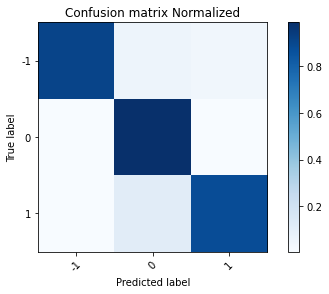

In [62]:
approach ='stemming+misspelling'
mode = '0 or 1, if the word exists'
evaluate_prediction(y_predicted.loc[approach, mode], y_test)

In [80]:
df.iloc[0,0]

"how unhappy  some dogs like it though,talking to my over driver about where i'm goinghe said he'd love to go to new york too but since trump it's probably not,does anybody know if the rand's likely to fall against the dollar? i got some money  i need to change into r but it keeps getting stronger unhappy"

In [78]:
text_processed[approach][0]

'unhappily dog like though talk driver going said love go new york since trump probabl anybody know rand like fall dollar got money need chang keep get strong unhappily'

In [81]:
text_processed['stemming'][0]

'unhappi dog like though talk driver goingh said love go new york sinc trump probabl anybodi know rand like fall dollar got money need chang keep get stronger unhappi'

In [92]:
text_processed['just tokenization'][0] 

'unhappy dogs like though talking driver goinghe said love go new york since trump probably anybody know rand likely fall dollar got money need change keeps getting stronger unhappy'

# Word2Vec

## training the model

In [73]:
import multiprocessing
import gensim
from gensim.models import Word2Vec

In [64]:
cores = multiprocessing.cpu_count()
cores = 1 if cores == 1 else cores - 1

The parameters:
* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* vector_size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

## Building the Vocabulary Table:

Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [93]:
approach = 'just tokenization'
text_processed[approach][0]

'unhappy dogs like though talking driver goinghe said love go new york since trump probably anybody know rand likely fall dollar got money need change keeps getting stronger unhappy'

In [94]:
t = time()
sentences = [sentence.split() for sentence in text_processed[approach]]
w2v_model = Word2Vec(sentences, vector_size=2000, min_count = 1, workers=cores-1)
t = round((time() - t) / 60, 2)
print(f'Time to build vocab: {t} mins')

2021-09-26 11:11:11,086 : INFO : collecting all words and their counts
2021-09-26 11:11:11,087 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-09-26 11:11:11,092 : INFO : collected 6091 word types from a corpus of 20149 raw words and 2708 sentences
2021-09-26 11:11:11,092 : INFO : Creating a fresh vocabulary
2021-09-26 11:11:11,106 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 6091 unique words (100.0%% of original 6091, drops 0)', 'datetime': '2021-09-26T11:11:11.106731', 'gensim': '4.1.1', 'python': '3.9.2 | packaged by conda-forge | (default, Feb 21 2021, 05:02:46) \n[GCC 9.3.0]', 'platform': 'Linux-5.10.25-linuxkit-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
2021-09-26 11:11:11,107 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 20149 word corpus (100.0%% of original 20149, drops 0)', 'datetime': '2021-09-26T11:11:11.107593', 'gensim': '4.1.1', 'python': '3.9.2 | packaged by conda-forge | (defa

Time to build vocab: 0.02 mins


In [102]:
w2v_model.wv.index_to_key[0:5]

['happy', 'unhappy', 'thanks', 'want', "n't"]

Example vector

In [96]:
word = w2v_model.wv.index_to_key[0:10][0]
print(word)
w2v_model.wv[word]

happy


array([ 2.1831524e-03, -2.6535292e-04,  1.9717871e-03, ...,
       -1.1191389e-03,  5.7883642e-04, -2.2107408e-05], dtype=float32)

Now we have a vector for each word. How do we get a vector for a sequence of words (aka a document)?
The most naive way is just to take an average. 

In [97]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if word in wv.index_to_key:
            if isinstance(wv[word], np.ndarray):
                mean.append(wv[word])
#         elif word in wv.vocab:
#             mean.append(wv.syn0norm[wv.vocab[word].index])
#             all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [98]:
%%time
X_word_average = word_averaging_list(w2v_model.wv, sentences)

2021-09-26 11:11:28,171 : WARNING : cannot compute similarity with no input []


CPU times: user 444 ms, sys: 4.88 ms, total: 449 ms
Wall time: 450 ms


accuracy = 0.887, precision = 0.897, recall = 0.887, f1 = 0.887
confusion matrix
 [[149  10   8]
 [  3 172   2]
 [  6  32 160]]
(row=expected, col=predicted)


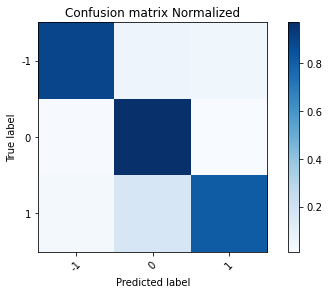

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_word_average, list_labels, stratify=list_labels, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predicted_w2v = lr.predict(X_test)
evaluate_prediction(y_predicted_w2v, y_test)